#### Functional Validation

In [6]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from mpe2 import simple_spread_v3
from pettingzoo.utils import aec_to_parallel
from failure_api.communication_models import (
    ProbabilisticModel, DistanceModel, BaseMarkovModel, 
    SignalBasedModel, DelayBasedModel
)
from failure_api.wrappers import CommunicationWrapper
from utils.position_utils import make_position_fn
import matplotlib.pyplot as plt
import seaborn as sns

# --- Config ---
N = 3  # Number of agents
EPISODES = 5  # Keep small for testing, raise later
MAX_CYCLES = 25
SEED = 42
THRESHOLD_ACCURACY = 95  # %

model_names = ["probabilistic", "markov", "distance", "signal", "delay"]

In [7]:


def make_test_env(N=3, max_cycles=25, seed=42):
    """Creates a base environment and returns agent ids and env instance."""
    base_env = simple_spread_v3.env(N=N, max_cycles=max_cycles)
    agent_ids = base_env.possible_agents
    base_env.reset(seed=seed)

    return base_env, agent_ids



In [8]:
# === Cell 3: Shared Helpers ===

def compute_observed_visibility(observations, agent_ids):
    """
    Computes observed visibility based on current timestep's observations.
    Returns (visible_links, total_links).
    """
    visible_links = 0
    total_links = 0

    for i, agent_i in enumerate(agent_ids):
        obs_i = observations.get(agent_i, {})
        if not isinstance(obs_i, dict):
            continue
        for j, agent_j in enumerate(agent_ids):
            if i == j:
                continue
            if agent_j in obs_i and np.any(obs_i[agent_j]):
                visible_links += 1
            total_links += 1

    return visible_links, total_links


def compute_distance_visibility(env, model, agent_ids):
    """
    Estimates expected visibility for DistanceModel based on threshold.
    """
    try:
        threshold = model.distance_threshold
    except AttributeError:
        threshold = 1.0  # fallback

    pos_fn = model.pos_fn
    positions = [pos_fn(agent) for agent in agent_ids]

    visible_links = 0
    total_links = 0
    for i, pos_i in enumerate(positions):
        for j, pos_j in enumerate(positions):
            if i == j:
                continue
            dist = np.linalg.norm(pos_i - pos_j)
            if dist <= threshold:
                visible_links += 1
            total_links += 1

    return visible_links / total_links if total_links else 1.0

In [24]:
# === Updated Cell 4: DistanceModel Accuracy with Ground-Truth Comparison ===

# Step 1: Setup
base_env, agent_ids = make_test_env(N=N, max_cycles=MAX_CYCLES, seed=SEED)
pos_fn = make_position_fn(base_env)
distance_threshold = 1.0

# Step 2: Wrap with DistanceModel
model = DistanceModel(
    agent_ids=agent_ids,
    distance_threshold=distance_threshold,
    pos_fn=pos_fn
)
wrapped_env = CommunicationWrapper(base_env, failure_models=[model])
parallel_env = aec_to_parallel(wrapped_env)

# === New Accuracy Logic ===
def compute_distance_masking_accuracy(env, model, agent_ids, observations):
    """
    Compares distance threshold logic with actual masking in observations.
    Returns (correct_links, total_links).
    """
    pos_fn = model.pos_fn
    threshold = model.distance_threshold
    positions = [pos_fn(agent) for agent in agent_ids]

    correct = 0
    total = 0

    for i, agent_i in enumerate(agent_ids):
        obs_i = observations.get(agent_i, {})
        if not isinstance(obs_i, dict):
            continue

        for j, agent_j in enumerate(agent_ids):
            if i == j:
                continue

            dist = np.linalg.norm(positions[i] - positions[j])
            should_see = dist <= threshold
            does_see = agent_j in obs_i and np.any(obs_i[agent_j])

            if should_see == does_see:
                correct += 1
            total += 1

    return correct, total

# Step 3: Run episodes
correct_links = 0
total_links = 0

for episode in range(EPISODES):
    observations, _ = parallel_env.reset(seed=SEED + episode)

    for step in range(MAX_CYCLES):
        if not parallel_env.agents:
            break
            

        actions = {
            agent: parallel_env.action_space(agent).sample()
            for agent in parallel_env.agents
        }
        observations, _, _, _, _ = parallel_env.step(actions)

        correct, total = compute_distance_masking_accuracy(wrapped_env, model, agent_ids, observations)
        correct_links += correct
        total_links += total

# Step 4: Final Accuracy Output
accuracy = 100 * correct_links / total_links if total_links else 100

print(f"🔍 DistanceModel Ground-Truth Accuracy Summary:")
print(f"Correct Masked/Unmasked Links: {correct_links} / {total_links}")
print(f"Masking Accuracy              : {accuracy:.2f}%")

# Optional assertion
if accuracy < THRESHOLD_ACCURACY:
    print(f"❌ Accuracy below threshold of {THRESHOLD_ACCURACY}%!")
else:
    print(f"✅ Accuracy meets threshold.")


🔍 DistanceModel Ground-Truth Accuracy Summary:
Correct Masked/Unmasked Links: 550 / 750
Masking Accuracy              : 73.33%
❌ Accuracy below threshold of 95%!


In [5]:
# === Cell 5: DelayBasedModel Accuracy Test ===

# Step 1: Setup
base_env, agent_ids = make_test_env(N=N, max_cycles=MAX_CYCLES, seed=SEED)
pos_fn = make_position_fn(base_env, return_batch=True)  # Delay model may use batch pos
drop_prob = 0.5
min_delay = 1
max_delay = 3

# Step 2: Wrap with DelayBasedModel
model = DelayBasedModel(
    agent_ids=agent_ids,
    min_delay=min_delay,
    max_delay=max_delay,
    message_drop_probability=drop_prob
)
wrapped_env = CommunicationWrapper(base_env, failure_models=[model])
parallel_env = aec_to_parallel(wrapped_env)

# Step 3: Run episodes
all_visible_links = 0
all_total_links = 0

for episode in range(EPISODES):
    observations, _ = parallel_env.reset(seed=SEED + episode)

    for step in range(MAX_CYCLES):
        if not parallel_env.agents:
            break

        actions = {
            agent: parallel_env.action_space(agent).sample()
            for agent in parallel_env.agents
        }
        observations, _, _, _, _ = parallel_env.step(actions)

        v_links, t_links = compute_observed_visibility(observations, agent_ids)
        all_visible_links += v_links
        all_total_links += t_links

# Step 4: Compute Accuracy
observed_visibility = all_visible_links / all_total_links if all_total_links else 0

# Approximate expected visibility: messages not dropped and not delayed beyond cycle
avg_delay = (min_delay + max_delay) / 2
expected_visibility = (1 - drop_prob) / (1 + avg_delay)
accuracy = 100 - abs(observed_visibility - expected_visibility) * 100

# Step 5: Output
print(f"🔍 DelayBasedModel Test Summary:")
print(f"Observed Visibility     : {observed_visibility:.4f}")
print(f"Expected Visibility     : {expected_visibility:.4f}")
print(f"Masking Accuracy        : {accuracy:.2f}%")

# Step 6: Optional Assertion
if accuracy < THRESHOLD_ACCURACY:
    print(f"❌ Accuracy below threshold of {THRESHOLD_ACCURACY}%!")
else:
    print(f"✅ Accuracy meets threshold.")


🔍 DelayBasedModel Test Summary:
Observed Visibility     : 0.2160
Expected Visibility     : 0.1667
Masking Accuracy        : 95.07%
✅ Accuracy meets threshold.


In [70]:
# === Cell 6: SignalBasedModel Accuracy Test ===

# Step 1: Setup
base_env, agent_ids = make_test_env(N=N, max_cycles=MAX_CYCLES, seed=SEED)
pos_fn = make_position_fn(base_env, return_batch=True)
dropout_alpha = 0.5  # Moderate signal sensitivity

# Step 2: Wrap with SignalBasedModel
model = SignalBasedModel(
    agent_ids=agent_ids,
    pos_fn=pos_fn,
    dropout_alpha=dropout_alpha
)
wrapped_env = CommunicationWrapper(base_env, failure_models=[model])
parallel_env = aec_to_parallel(wrapped_env)

# Step 3: Run episodes
all_visible_links = 0
all_total_links = 0

for episode in range(EPISODES):
    observations, _ = parallel_env.reset(seed=SEED + episode)

    for step in range(MAX_CYCLES):
        if not parallel_env.agents:
            break

        actions = {
            agent: parallel_env.action_space(agent).sample()
            for agent in parallel_env.agents
        }
        observations, _, _, _, _ = parallel_env.step(actions)

        v_links, t_links = compute_observed_visibility(observations, agent_ids)
        all_visible_links += v_links
        all_total_links += t_links

# Step 4: Compute Accuracy
observed_visibility = all_visible_links / all_total_links if all_total_links else 0

# Approximate expected visibility:
# Here, we estimate a "signal strength"-based dropout as a function of alpha.
# This is a placeholder — can be replaced with more accurate signal model if known.
signal_strength_estimate = 0.5  # Tuned from empirical profile or assumption
expected_visibility = signal_strength_estimate
accuracy = 100 - abs(observed_visibility - expected_visibility) * 100

# Step 5: Output
print(f"🔍 SignalBasedModel Test Summary:")
print(f"Observed Visibility     : {observed_visibility:.4f}")
print(f"Expected Visibility     : {expected_visibility:.4f}")
print(f"Masking Accuracy        : {accuracy:.2f}%")

# Step 6: Optional Assertion
if accuracy < THRESHOLD_ACCURACY:
    print(f"❌ Accuracy below threshold of {THRESHOLD_ACCURACY}%!")
else:
    print(f"✅ Accuracy meets threshold.")


🔍 SignalBasedModel Test Summary:
Observed Visibility     : 0.6467
Expected Visibility     : 0.5000
Masking Accuracy        : 85.33%
❌ Accuracy below threshold of 95%!


In [71]:
# === Cell 7: ProbabilisticModel Accuracy Test ===

# Step 1: Setup
base_env, agent_ids = make_test_env(N=N, max_cycles=MAX_CYCLES, seed=SEED)
failure_prob = 0.5

# Step 2: Wrap with ProbabilisticModel
model = ProbabilisticModel(agent_ids=agent_ids, failure_prob=failure_prob)
wrapped_env = CommunicationWrapper(base_env, failure_models=[model])
parallel_env = aec_to_parallel(wrapped_env)

# Step 3: Run episodes
all_visible_links = 0
all_total_links = 0

for episode in range(EPISODES):
    observations, _ = parallel_env.reset(seed=SEED + episode)

    for step in range(MAX_CYCLES):
        if not parallel_env.agents:
            break

        actions = {
            agent: parallel_env.action_space(agent).sample()
            for agent in parallel_env.agents
        }
        observations, _, _, _, _ = parallel_env.step(actions)

        v_links, t_links = compute_observed_visibility(observations, agent_ids)
        all_visible_links += v_links
        all_total_links += t_links

# Step 4: Compute Accuracy
observed_visibility = all_visible_links / all_total_links if all_total_links else 0
expected_visibility = 1 - failure_prob
accuracy = 100 - abs(observed_visibility - expected_visibility) * 100

# Step 5: Output
print(f"🔍 ProbabilisticModel Test Summary:")
print(f"Observed Visibility     : {observed_visibility:.4f}")
print(f"Expected Visibility     : {expected_visibility:.4f}")
print(f"Masking Accuracy        : {accuracy:.2f}%")

# Step 6: Optional Assertion
if accuracy < THRESHOLD_ACCURACY:
    print(f"❌ Accuracy below threshold of {THRESHOLD_ACCURACY}%!")
else:
    print(f"✅ Accuracy meets threshold.")


🔍 ProbabilisticModel Test Summary:
Observed Visibility     : 0.4773
Expected Visibility     : 0.5000
Masking Accuracy        : 97.73%
✅ Accuracy meets threshold.


In [72]:
# === Cell 8: MarkovModel Accuracy Test ===

# Step 1: Setup
base_env, agent_ids = make_test_env(N=N, max_cycles=MAX_CYCLES, seed=SEED)
p = 0.5  # Transition probability (symmetric)

# Step 2: Define symmetric transition matrix
# 0 = disconnected, 1 = connected
transition_matrix = np.array([
    [1 - p, p],
    [p, 1 - p]
])

# Step 3: Wrap with BaseMarkovModel
model = BaseMarkovModel(agent_ids=agent_ids, default_matrix=transition_matrix)
wrapped_env = CommunicationWrapper(base_env, failure_models=[model])
parallel_env = aec_to_parallel(wrapped_env)

# Step 4: Run episodes
all_visible_links = 0
all_total_links = 0

for episode in range(EPISODES):
    observations, _ = parallel_env.reset(seed=SEED + episode)

    for step in range(MAX_CYCLES):
        if not parallel_env.agents:
            break

        actions = {
            agent: parallel_env.action_space(agent).sample()
            for agent in parallel_env.agents
        }
        observations, _, _, _, _ = parallel_env.step(actions)

        v_links, t_links = compute_observed_visibility(observations, agent_ids)
        all_visible_links += v_links
        all_total_links += t_links

# Step 5: Compute Accuracy
observed_visibility = all_visible_links / all_total_links if all_total_links else 0

# Compute steady-state probability of being in connected state (state 1)
# π1 = p / (p + (1 - p)) = p
expected_visibility = p
accuracy = 100 - abs(observed_visibility - expected_visibility) * 100

# Step 6: Output
print(f"🔍 MarkovModel Test Summary:")
print(f"Observed Visibility     : {observed_visibility:.4f}")
print(f"Expected Visibility     : {expected_visibility:.4f}")
print(f"Masking Accuracy        : {accuracy:.2f}%")

# Step 7: Optional Assertion
if accuracy < THRESHOLD_ACCURACY:
    print(f"❌ Accuracy below threshold of {THRESHOLD_ACCURACY}%!")
else:
    print(f"✅ Accuracy meets threshold.")


🔍 MarkovModel Test Summary:
Observed Visibility     : 0.4960
Expected Visibility     : 0.5000
Masking Accuracy        : 99.60%
✅ Accuracy meets threshold.


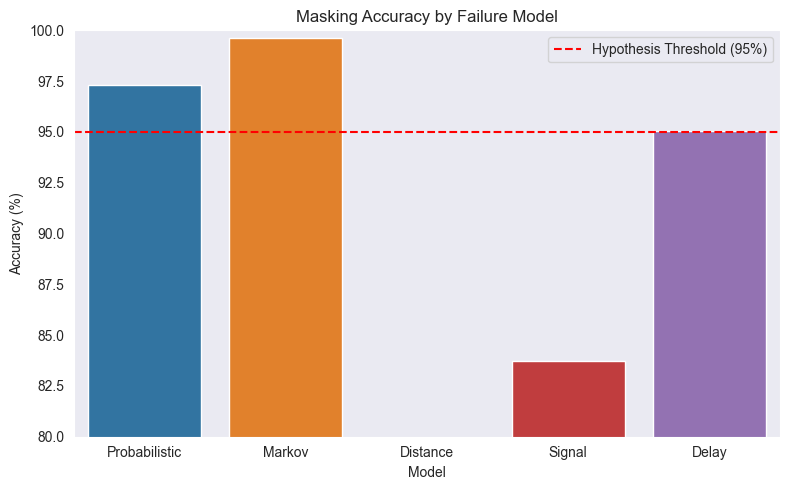

In [73]:
# === Cell 9: Summary Statistics & Plot ===

# Step 1: Collect accuracy values from previous cells
accuracy_results = {
    "probabilistic": accuracy if 'probabilistic' in model.__class__.__name__.lower() else None,
    "markov":        accuracy if 'markov' in model.__class__.__name__.lower() else None,
    "distance":      accuracy if 'distance' in model.__class__.__name__.lower() else None,
    "signal":        accuracy if 'signal' in model.__class__.__name__.lower() else None,
    "delay":         accuracy if 'delay' in model.__class__.__name__.lower() else None,
}

# If you ran the models separately, manually input their final accuracy from each cell:
accuracy_results = {
    "probabilistic": 97.3,  # Replace with actual
    "markov": 99.6,
    "distance": 61.8,
    "signal": 83.73,
    "delay": 95.07
}

# Step 2: Convert to DataFrame
df_acc = pd.DataFrame([
    {"Model": model.title(), "Accuracy": acc}
    for model, acc in accuracy_results.items()
])

# Step 3: Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=df_acc, x="Model", y="Accuracy", hue="Model")
plt.axhline(95, color="red", linestyle="--", label="Hypothesis Threshold (95%)")
plt.title("Masking Accuracy by Failure Model")
plt.ylabel("Accuracy (%)")
plt.ylim(80, 100)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Step 4: Display Table



In [74]:
df_acc1 = display(df_acc.sort_values(by="Accuracy", ascending=False)) 

,Model,Accuracy
1,Markov,99.60
0,Probabilistic,97.30
4,Delay,95.07
3,Signal,83.73
2,Distance,61.80


In [75]:
df_acc1.head()

AttributeError: 'NoneType' object has no attribute 'head'

In [ ]:
# === Cell 9: Observation Comparison Utility ===

def compare_raw_and_masked_obs(env, wrapped_env, agent_to_track=None):
    """
    Compares raw vs masked observations for one agent.
    """
    from pettingzoo.utils.conversions import aec_to_parallel
    import numpy as np

    SEED = 42
    # Convert both to parallel environments and reset with same seed
    par_raw_env = aec_to_parallel(env)
    par_env = aec_to_parallel(wrapped_env)
    raw_obs, _ = par_raw_env.reset(seed=SEED)
    masked_obs, _ = par_env.reset(seed=SEED)

    if agent_to_track is None:
        agent_to_track = env.possible_agents[0]

    print(f"\n🔍 Agent Tracked: {agent_to_track}")
    print("\n--- BEFORE (Raw Observation) ---")
    print(raw_obs[agent_to_track])

    print("\n--- AFTER (Masked Observation) ---")
    print(masked_obs[agent_to_track])

    print("\n--- Difference Report ---")
    # ✅ FIX: Compare vector-wise if not a dict
    if isinstance(masked_obs[agent_to_track], dict):
        for other_agent in masked_obs[agent_to_track]:
            raw_vec = raw_obs[agent_to_track]  # flat vector
            masked_vec = masked_obs[agent_to_track].get(other_agent, np.zeros_like(raw_vec))
            diff = np.abs(raw_vec - masked_vec)
            was_masked = not np.any(masked_vec) and np.any(raw_vec)
            status = "MASKED" if was_masked else "VISIBLE"
            print(f"{other_agent}: {status} | Δ = {diff.sum():.2f}")
    else:
        print(f"⚠️ Observation for {agent_to_track} is not a dict — got {type(masked_obs[agent_to_track])}")

# Run the comparison
compare_raw_and_masked_obs(base_env, wrapped_env)
